<a href="https://colab.research.google.com/github/mariocsp/Project_AI_2023/blob/main/LSTM_And_LSTM_auto_encoder_for_error_binary_classification_using_multilple_feature_The_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perbedaan utama metode yang kami gunakan dari paper adalah metode pada paper melakukan prediksi terlebih dahulu. Pada paper ,model di train hanya menggunakan data run normal sehingga model dapat memprediksi dengan tepat. Klasifikasi atau deteksi anomaly dilakukan dengan melakukan prediksi pada data, jika error prediksi besar maka data dikategorikan sebagai anomali. Pendekatan yang kami lakukan adalah dengan langsung mengklasifikasi time series tanpa adanya prediksi menggunakan lstm dan encoder-decoder lstm. Untuk kedepannya kami ingin mencoba menggunakan model convlstm, convtran, dan RNN tipe GRU untuk melakukan klasifikasi.

# Menginstall dan Mengimport library yang dibutuhkan

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchmetrics.functional import accuracy
from torch.nn import functional

from tqdm.auto import tqdm
from timeit import default_timer
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

device = 'cuda' if torch.cuda.is_available() else "cpu"

#Load dan pengolahan data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/Shareddrives/AI/AI2023/hvcm/CCL'
features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX', 
         'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']  

Mounted at /content/drive


In [4]:
Y = np.load(f'{path}_labels.npy', allow_pickle=True)

In [5]:
df_normalize = pd.read_csv(f"{path}_normalize.csv")
df_normalize.head(10)

,Unnamed: 0.1,Unnamed: 0,timeseries_idx,A+IGBT-I,A+*IGBT-I,B+IGBT-I,B+*IGBT-I,C+IGBT-I,C+*IGBT-I,A-FLUX,B-FLUX,C-FLUX,MOD-V,MOD-I,CB-I,CB-V,DV/DT
0,0,0,0.0,0.625857,0.621531,0.636062,0.615522,0.626562,0.632367,-0.069420,-0.31591,-0.33798,-1.564395,-0.001011,0.045519,0.530564,0.086791
1,1,1,0.0,0.625857,0.624902,0.630980,0.618888,0.626562,0.642766,-0.093835,-0.30370,-0.31357,-1.565259,-0.051549,0.045519,0.518591,-0.003827
2,2,2,0.0,0.629316,0.624902,0.632674,0.618888,0.651726,0.637566,-0.118250,-0.27929,-0.31357,-1.564395,-0.026280,0.015000,0.519548,-0.034032
3,3,3,0.0,0.625857,0.621531,0.632674,0.620571,0.628240,0.632367,-0.106040,-0.30370,-0.32578,-1.563098,-0.051549,-0.046037,0.527212,-0.064237
4,4,4,0.0,0.631046,0.621531,0.636062,0.620571,0.651726,0.634101,-0.093835,-0.29149,-0.33798,-1.563962,-0.001011,0.015000,0.529127,-0.079339
5,5,5,0.0,0.625857,0.621531,0.630980,0.620571,0.624884,0.635833,-0.142660,-0.29149,-0.32578,-1.564395,-0.026280,0.015000,0.518591,0.132098
6,6,6,0.0,0.627587,0.621531,0.630980,0.620571,0.650048,0.635833,-0.106040,-0.26708,-0.32578,-1.563962,-0.026280,0.045519,0.519548,0.011274
7,7,7,0.0,0.629316,0.619845,0.634368,0.622254,0.603076,0.635833,-0.093835,-0.29149,-0.35019,-1.563962,-0.001011,0.015000,0.532001,-0.064237
8,8,8,0.0,0.627587,0.621531,0.634368,0.620571,0.624884,0.641034,-0.081628,-0.27929,-0.30136,-1.563530,0.049528,0.015000,0.524817,-0.079339
9,9,9,0.0,0.629316,0.621531,0.630980,0.622254,0.623206,0.632367,-0.069420,-0.27929,-0.36240,-1.564827,0.024259,0.045519,0.520027,-0.034032


In [6]:
label_binary = Y[:,1]
label_multiclass = Y[:,2]

df_label = pd.DataFrame([label_binary,label_multiclass]).transpose()
df_label.columns = ['label_binary', 'label_multiclass']

label_binary = df_label['label_binary'] == 'Run'
label_binary = label_binary.astype(np.int32)

df_label['label_binary'] = label_binary
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label_binary      2057 non-null   int32 
 1   label_multiclass  2057 non-null   object
dtypes: int32(1), object(1)
memory usage: 24.2+ KB


In [7]:
sequence = []

for timeseries_idx, group in df_normalize.groupby('timeseries_idx'):
  seq_feat = group[features]
  label = df_label['label_binary'][timeseries_idx]
  label = np.float32(label)
  sequence.append([seq_feat,label])

In [8]:
sequence = np.array(sequence)
train_seq, test_seq = train_test_split(sequence, train_size=0.8, shuffle=True)

<ipython-input-8-6804968c2bb1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequence = np.array(sequence)


In [9]:
test_seq.shape

(412, 2)

In [10]:
train_seq.shape

(1645, 2)

In [11]:
train_data = []

for i,(seq,label) in enumerate(train_seq):
  sequ = torch.Tensor(seq.to_numpy())
  labeli = torch.Tensor([label])

  train_data.append((sequ,labeli))

In [12]:
test_data = []

for i,(seq,label) in enumerate(test_seq):
  sequ = torch.Tensor(seq.to_numpy())
  labeli = torch.Tensor([label])

  test_data.append((sequ,labeli))

In [13]:
BATCH = 64
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH,
                              shuffle = True,
                              drop_last = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH,
                             shuffle = False)

In [14]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))


print(f"""

tipe loader train:{type(train_dataloader)}
tipe loader test :{type(test_dataloader)}
jumlah batch train: {len(train_dataloader)}
jumlah batch test: {len(test_dataloader)}
bentuk batch fitur: {train_feature_batch.shape}
bentuk batch label: {train_label_batch.shape}

""")



tipe loader train:<class 'torch.utils.data.dataloader.DataLoader'>
tipe loader test :<class 'torch.utils.data.dataloader.DataLoader'>
jumlah batch train: 25
jumlah batch test: 7
bentuk batch fitur: torch.Size([64, 4500, 14])
bentuk batch label: torch.Size([64, 1])




# Fungsi - Fungsi Untuk Training dan Evaluasi Model

fungsi untuk mentrain model

In [15]:

def train_loop(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.modules, 
               optimizer: torch.optim.Optimizer,
               device:torch.device = device,
               scheduler=None):
  
  loss_train = 0
  acc_train = 0

  list_loss_train = []
  list_acc_train = []


  model.to(device)

  model.train()

  for batch, (X,y) in enumerate(train_dataloader):
    
    X = X.to(device)
    y = y.to(device)
  
    optimizer.zero_grad()

    logit = model(X)
    pred = torch.round(torch.sigmoid(logit))

    loss = loss_fn(logit,y)
    loss_train += loss
    loss.backward()
    optimizer.step()
      
    acc = accuracy(pred,y,task='binary').item()
    acc_train += acc

    list_loss_train.append(loss.item())
    list_acc_train.append(acc)

    if batch%(len(train_dataloader)//10) == 0:
      print(f'batch ke - {batch}')
  
    if not scheduler == None:
      scheduler.step()
  
  pembagi_train = len(train_dataloader)
  loss_train = loss_train/pembagi_train
  acc_train = acc_train/pembagi_train

  dict_metrics = {"model": model.__class__.__name__,
                  "loss": loss_train.item(),
                  "akurasi": acc_train}
  

  print(f"""
  loss_train     = {loss_train:.4f}
  train_accuracy = {acc_train:.4f}
  """)


  return dict_metrics,list_loss_train,list_acc_train

fungsi untuk validasi hasil training

In [16]:
def model_metrics(model:torch.nn.Module,
                  test_dataloader:torch.utils.data.DataLoader,
                  loss_fn: torch.nn.modules):
  
  model.to(device)
  model.eval()

  list_loss_test = []
  list_acc_test = []

  loss_test = 0
  acc_test = 0
  with torch.inference_mode():

    for batch, (X,y) in enumerate(test_dataloader):
      X = X.to(device)
      y = y.to(device)

      logit = model(X)
      loss = loss_fn(logit,y)
    
      loss_test += loss
      pred = torch.round(torch.sigmoid(logit))

      acc = accuracy(pred,y,task='binary').item()
      acc_test += acc

      list_loss_test.append(loss.item())
      list_acc_test.append(acc)
      
    pembagi_test = len(test_dataloader)
   
    loss_test = loss_test/pembagi_test
    acc_test = acc_test/pembagi_test
      
  dict_metrics = {"model": model.__class__.__name__,
                  "loss": loss_test.item(),
                  "akurasi": acc_test}

  print(f"""
  loss_test     = {loss_test:.4f}
  test_accuracy = {acc_test:.4f}
  """)

  return dict_metrics, list_loss_test, list_acc_test

fungsi untuk visualisasi hasil training dan validasi

In [17]:
def manual_tensorboard(dict_info:dict):
  fig, axs = plt.subplots(2,2)
  fig.set_figheight(12)
  fig.set_figwidth(12)
  for j,i in enumerate(dict_info):
    value = dict_info[i]
    x = np.linspace(0,100,len(value))
    fig.add_subplot(2, 2, j+ 1 )
    plt.plot(x,value)
    plt.xlabel('Time (s)')
    plt.title(i) 
    plt.xticks([])
    plt.yticks([])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
  fig.show()

  return True


fungsi untuk menampilkan confusion matrix

In [18]:
def confusion_metric(model, dataloader):
  y_preds = []
  labels = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader, desc="Making predictions"):
      X, y = X.to(device), y.to(device)
      y_logit = model(X)
      y_pred = torch.round(torch.sigmoid(y_logit))
      y_preds.append(y_pred.cpu())
      labels.append(y.cpu())
    
    y_pred_tensor = torch.cat(y_preds)
    labels = torch.cat(labels)

    confmat = ConfusionMatrix(num_classes=2, task='binary')
    confmat_tensor = confmat(preds=y_pred_tensor,
                         target=labels)
    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
        figsize=(10, 7)
        );

    return True


# Training model 0

Definisikan model

In [19]:
class Classification_modelv0(nn.Module):
  def __init__(self,input_dim,nodes,output_dim,layer):
    super().__init__()
    self.nodes = nodes
    self.lstm = nn.LSTM(
        input_size = input_dim,
        hidden_size = nodes,
        num_layers = layer,
        batch_first = True,
        )
    
    self.classifier = nn.Linear(nodes,output_dim)
   

  def forward(self,x):
    self.lstm.flatten_parameters()
    _,(hidden,_) = self.lstm(x)

    out = hidden[-1]

    return self.classifier(out)

inisialisasi model

In [20]:
torch.manual_seed(21)
model_0 = Classification_modelv0(input_dim = 14,nodes = 128, 
                                 output_dim = 1, layer =  3)
print(model_0)

Classification_modelv0(
  (lstm): LSTM(14, 128, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


mengamati bentuk keluaran model

In [21]:
with torch.inference_mode():
  dummy_image = torch.rand([2,28,14])
  y_pred = model_0(dummy_image)

print(y_pred.shape)
print(y_pred)

torch.Size([2, 1])
tensor([[-0.0611],
        [-0.0606]])


mendefinisikan loss function, otimizer, dan scheduler jika dibutuhkan

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params = model_0.parameters())


print(type(loss_fn))
print(type(optimizer))


<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adamw.AdamW'>


proses training

In [23]:
epochs = 15

dict_info = {'loss_train':[],
             'acc_train':[],
             'loss_test':[],
             'acc_test':[]}

for epoch in range(epochs):
  print(f"epoch--{epoch}\n________")
  log_train,l,a = train_loop(model_0,
                         train_dataloader,
                         loss_fn,
                         optimizer,
                         device)
  
  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  
  if epoch%(epochs//10) == 0:
    log_test,lt,at = model_metrics(model_0,test_dataloader,loss_fn)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
  

epoch--0
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 24

  loss_train     = 0.4586
  train_accuracy = 0.8281
  

  loss_test     = 0.4116
  test_accuracy = 0.8562
  
epoch--1
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 24

  loss_train     = 0.3881
  train_accuracy = 0.8694
  

  loss_test     = 0.4077
  test_accuracy = 0.8629
  
epoch--2
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 24

  loss_train     = 0.3606
  train_accuracy = 0.8856
  

  loss_test     = 0.3954
  test_accuracy = 0.8651
  
epoch--3
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
ba

# Evaluasi Model 0

True

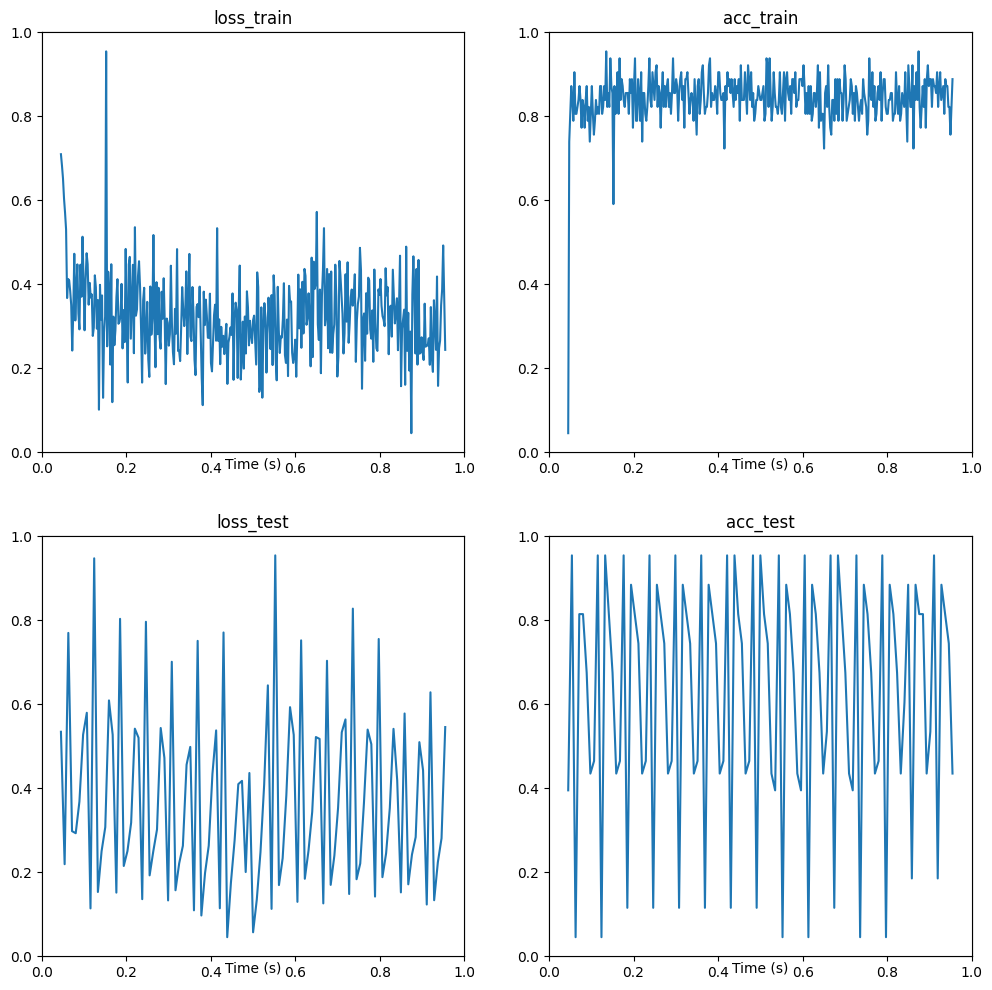

In [24]:
manual_tensorboard(dict_info)

In [25]:
"""
torch.save(model_0.state_dict(),path + ".pth")
"""

print('run this only when you get good result')

run this only when you get good result


In [26]:
model_0_inf = Classification_modelv0(input_dim = 14,nodes = 128, 
                                 output_dim = 1, layer =  3)

state0 = torch.load(path + ".pth")
model_0_inf.load_state_dict(state0)


<All keys matched successfully>

In [27]:
log_train

{'model': 'Classification_modelv0',
 'loss': 0.31665468215942383,
 'akurasi': 0.895}

In [28]:
log_test

{'model': 'Classification_modelv0',
 'loss': 0.3610718846321106,
 'akurasi': 0.8695790852819171}

Making predictions:   0%|          | 0/25 [00:00<?, ?it/s]

True

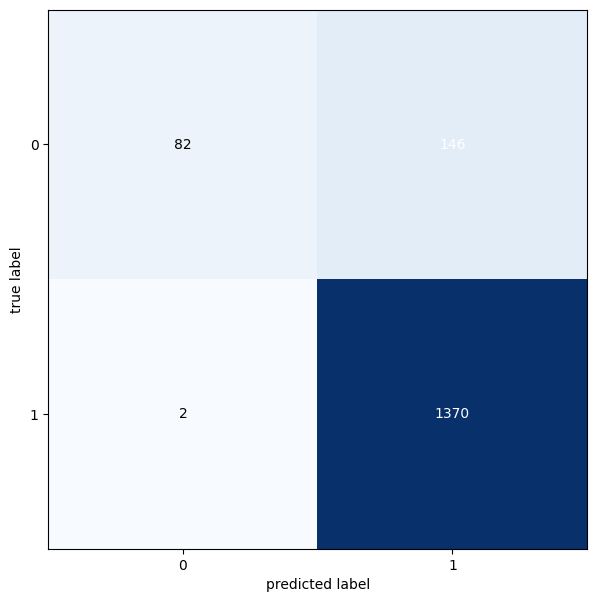

In [29]:
confusion_metric(model_0_inf,train_dataloader)

Making predictions:   0%|          | 0/7 [00:00<?, ?it/s]

True

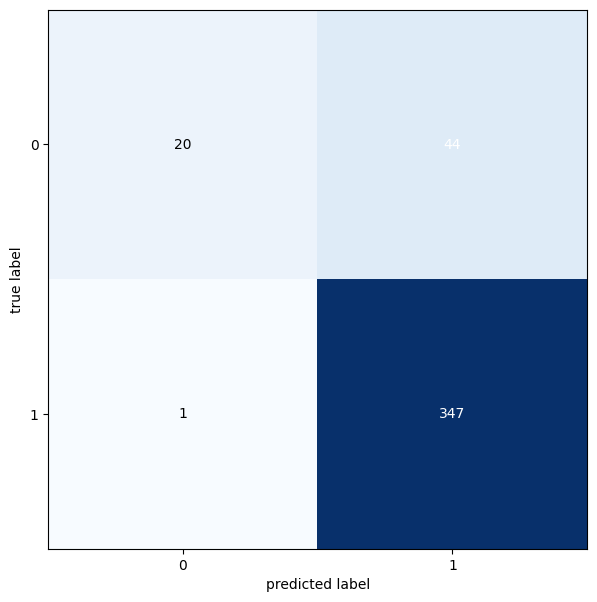

In [30]:
confusion_metric(model_0_inf,test_dataloader)

# Load dan olah dataset untuk menyamakan frekuensi data

In [31]:
X = np.load(f'{path}.npy')

In [32]:
Y_bin = label_binary.to_numpy()
fault_indices, normal_indices = np.where(Y_bin == 0)[0], np.where(Y_bin == 1)[0]

normal_indices = np.random.choice(normal_indices,size = 500)

Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]  
Ynormal, Yanomaly = Y_bin[normal_indices], Y_bin[fault_indices]   

In [33]:
X_freq = np.concatenate((Xnormal,Xanomaly))
Y_freq = np.concatenate((Ynormal,Yanomaly))

X_train, X_test, y_train, y_test = train_test_split(X_freq, Y_freq, test_size=0.25, random_state=42)

In [34]:
train_freq = []
for seq,label in zip(X_train,y_train):
  train_freq.append((seq,np.float32([label])))


In [35]:
test_freq = []
for seq,label in zip(X_test,y_test):
  test_freq.append((seq,np.float32([label])))

In [36]:
print(len(train_freq),len(test_freq))

603 202


In [37]:
BATCH = 32
train_freq_dataloader = DataLoader(train_freq,
                        batch_size = BATCH,
                        shuffle = True,
                        drop_last = True)

test_freq_dataloader = DataLoader(test_freq,
                             batch_size = BATCH,
                             shuffle = False,
                              drop_last = True)

# Training model_1 (menyeimbangkan frekuensi run dan fault, lalu mencobanya pada model encoder dan decoder)

In [38]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True)

    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True)

  def forward(self, x):

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n

In [39]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, 1)

  def forward(self, x):

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    

    return self.output_layer(x).squeeze(dim = 0)

In [40]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [41]:
torch.manual_seed(22)
model_1 =  RecurrentAutoencoder(seq_len= 4500, n_features = 14,embedding_dim=128)
model_1

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(14, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [42]:
dummy_image = torch.rand([2,4500,14])
y_pred = model_1(dummy_image.to(device))

print(y_pred.shape)
print(y_pred)

torch.Size([2, 1])
tensor([[-0.0512],
        [-0.0513]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [43]:
loss_fn1 = nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.Adam(params = model_1.parameters(),lr = 0.0001)#,weight_decay = 0.0001)
scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer1, 
                                               start_factor=0.3333333333333333, 
                                               end_factor=1.0, total_iters=5, 
                                               last_epoch=- 1, verbose=False)

print(type(loss_fn1))
print(type(optimizer1))
print(type(scheduler1))

<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [44]:
epochs = 100

dict_info = {'loss_train':[],
             'acc_train':[],
             'loss_test':[],
             'acc_test':[]}

for epoch in range(epochs):
  print(f"epoch--{epoch}\n________")
  log_train,l,a = train_loop(model_1,
                         train_freq_dataloader,
                         loss_fn1,
                         optimizer1,
                         device,
                         scheduler1)
  
  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  
  if epoch%(epochs//10) == 0:
    log_test,lt,at = model_metrics(model_1,test_freq_dataloader,loss_fn1)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
  

epoch--0
________
batch ke - 0
batch ke - 1
batch ke - 2
batch ke - 3
batch ke - 4
batch ke - 5
batch ke - 6
batch ke - 7
batch ke - 8
batch ke - 9
batch ke - 10
batch ke - 11
batch ke - 12
batch ke - 13
batch ke - 14
batch ke - 15
batch ke - 16
batch ke - 17

  loss_train     = 0.6925
  train_accuracy = 0.4861
  

  loss_test     = 0.6829
  test_accuracy = 0.6146
  
epoch--1
________
batch ke - 0
batch ke - 1
batch ke - 2
batch ke - 3
batch ke - 4
batch ke - 5
batch ke - 6
batch ke - 7
batch ke - 8
batch ke - 9
batch ke - 10
batch ke - 11
batch ke - 12
batch ke - 13
batch ke - 14
batch ke - 15
batch ke - 16
batch ke - 17

  loss_train     = 0.6690
  train_accuracy = 0.6267
  
epoch--2
________
batch ke - 0
batch ke - 1
batch ke - 2
batch ke - 3
batch ke - 4
batch ke - 5
batch ke - 6
batch ke - 7
batch ke - 8
batch ke - 9
batch ke - 10
batch ke - 11
batch ke - 12
batch ke - 13
batch ke - 14
batch ke - 15
batch ke - 16
batch ke - 17

  loss_train     = 0.6627
  train_accuracy = 0.6267
 

# Evaluasi Model_1

True

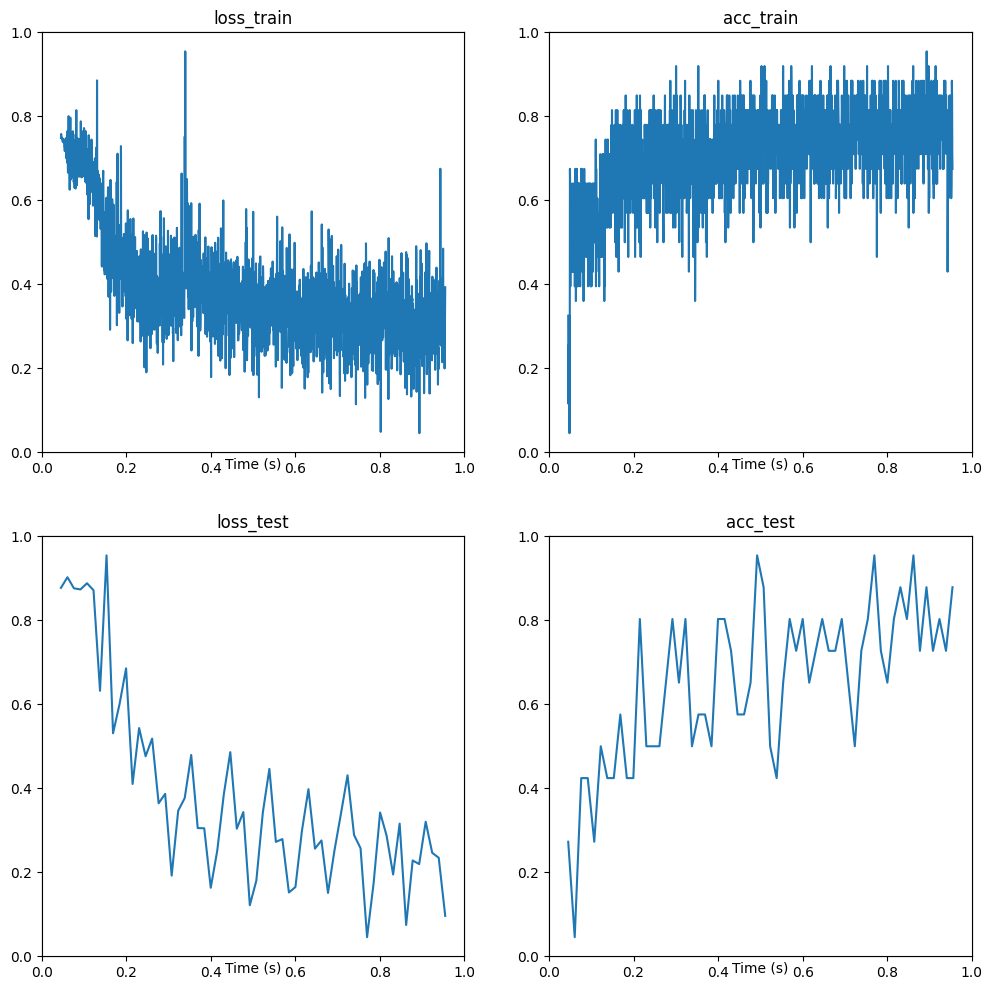

In [45]:
manual_tensorboard(dict_info)

In [46]:
log_test

{'model': 'RecurrentAutoencoder',
 'loss': 0.34339141845703125,
 'akurasi': 0.8072916666666666}

In [47]:
log_train

{'model': 'RecurrentAutoencoder',
 'loss': 0.31333744525909424,
 'akurasi': 0.8211805555555556}

In [48]:
"""
torch.save(model_1.state_dict(),path + "1.pth")
"""

print('run only when you get good result')

run only when you get good result


In [49]:
model_1_inf = RecurrentAutoencoder(seq_len= 4500, n_features = 14,embedding_dim=128)

state = torch.load(path + "1.pth")
model_1_inf.load_state_dict(state)

<All keys matched successfully>

Making predictions:   0%|          | 0/18 [00:00<?, ?it/s]

True

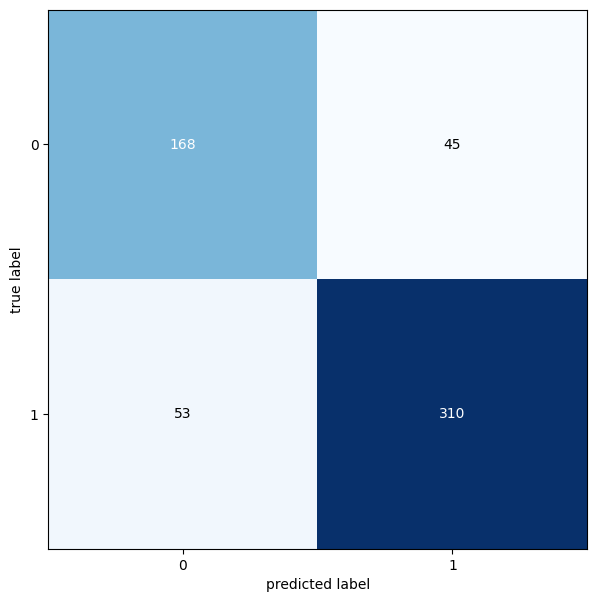

In [50]:
confusion_metric(model_1_inf,train_freq_dataloader)

Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

True

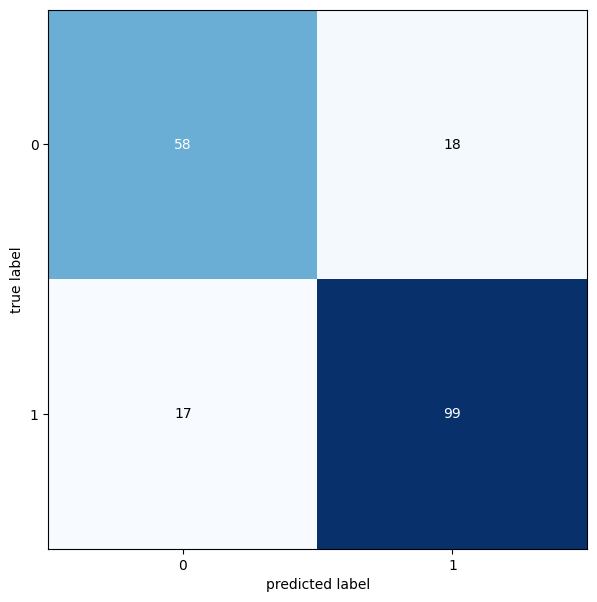

In [51]:
confusion_metric(model_1_inf,test_freq_dataloader)

# Training Model 2 (model 0 namun menggunakan data dengan frekuensi run dan fault yang berimbang dan menggunakan scheduler saat training)

In [52]:
torch.manual_seed(21)
model_2 = Classification_modelv0(input_dim = 14,nodes = 128, 
                                 output_dim = 1, layer =  3)
print(model_2)

Classification_modelv0(
  (lstm): LSTM(14, 128, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


In [53]:
loss_fn2 = nn.BCEWithLogitsLoss()
optimizer2 = torch.optim.Adam(params = model_2.parameters(),lr = 0.0001)#,weight_decay = 0.0001)
scheduler2 = torch.optim.lr_scheduler.LinearLR(optimizer2, 
                                               start_factor=0.3333333333333333, 
                                               end_factor=1.0, total_iters=5, 
                                               last_epoch=- 1, verbose=False)

print(type(loss_fn2))
print(type(optimizer2))
print(type(scheduler2))

<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [54]:
epochs = 100

dict_info = {'loss_train':[],
             'acc_train':[],
             'loss_test':[],
             'acc_test':[]}

for epoch in range(epochs):
  print(f"epoch--{epoch}\n________")
  log_train,l,a = train_loop(model_2,
                         train_freq_dataloader,
                         loss_fn2,
                         optimizer2,
                         device,
                         scheduler2)
  
  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  
  if epoch%(epochs//10) == 0:
    log_test,lt,at = model_metrics(model_2,test_freq_dataloader,loss_fn2)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
  

epoch--0
________
batch ke - 0
batch ke - 1
batch ke - 2
batch ke - 3
batch ke - 4
batch ke - 5
batch ke - 6
batch ke - 7
batch ke - 8
batch ke - 9
batch ke - 10
batch ke - 11
batch ke - 12
batch ke - 13
batch ke - 14
batch ke - 15
batch ke - 16
batch ke - 17

  loss_train     = 0.6897
  train_accuracy = 0.5226
  

  loss_test     = 0.6749
  test_accuracy = 0.6406
  
epoch--1
________
batch ke - 0
batch ke - 1
batch ke - 2
batch ke - 3
batch ke - 4
batch ke - 5
batch ke - 6
batch ke - 7
batch ke - 8
batch ke - 9
batch ke - 10
batch ke - 11
batch ke - 12
batch ke - 13
batch ke - 14
batch ke - 15
batch ke - 16
batch ke - 17

  loss_train     = 0.6586
  train_accuracy = 0.6580
  
epoch--2
________
batch ke - 0
batch ke - 1
batch ke - 2
batch ke - 3
batch ke - 4
batch ke - 5
batch ke - 6
batch ke - 7
batch ke - 8
batch ke - 9
batch ke - 10
batch ke - 11
batch ke - 12
batch ke - 13
batch ke - 14
batch ke - 15
batch ke - 16
batch ke - 17

  loss_train     = 0.6229
  train_accuracy = 0.6684
 

# Evaluasi Model_2

In [55]:
log_train

{'model': 'Classification_modelv0',
 'loss': 0.29988783597946167,
 'akurasi': 0.8229166666666666}

In [56]:
log_test

{'model': 'Classification_modelv0',
 'loss': 0.38813742995262146,
 'akurasi': 0.796875}

In [57]:
"""
torch.save(model_2.state_dict(),path + "2.pth")
"""

print('run only when you get good result')

run only when you get good result


In [58]:
model_2_inf = Classification_modelv0(input_dim = 14,nodes = 128, 
                                 output_dim = 1, layer =  3)

state2 = torch.load(path + "2.pth")
model_2_inf.load_state_dict(state2)


<All keys matched successfully>

True

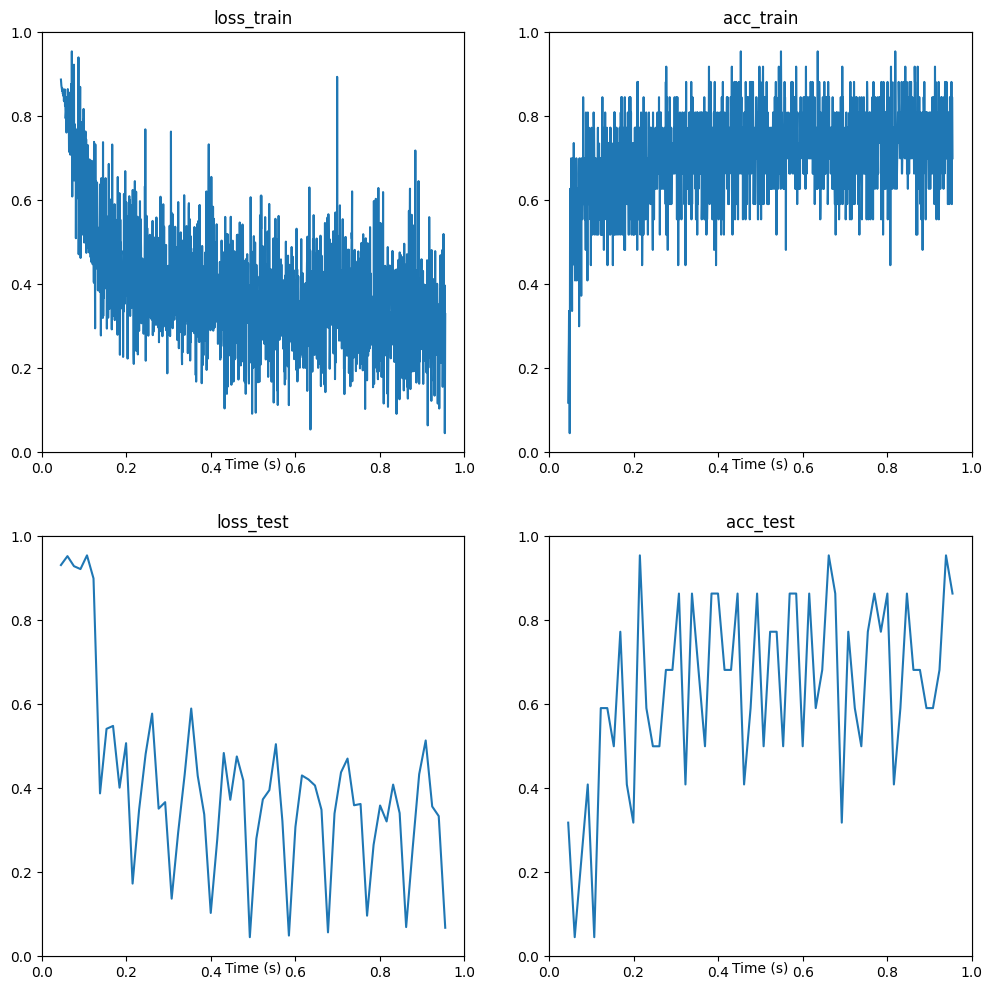

In [59]:
manual_tensorboard(dict_info)

Making predictions:   0%|          | 0/18 [00:00<?, ?it/s]

True

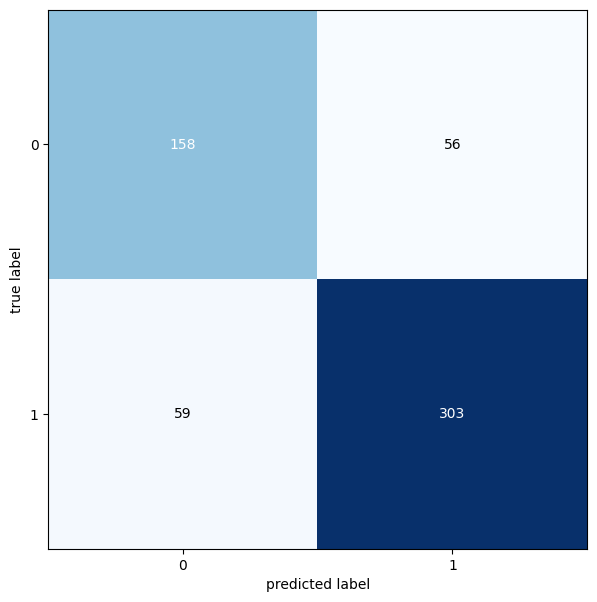

In [60]:
confusion_metric(model_2_inf,train_freq_dataloader)

Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

True

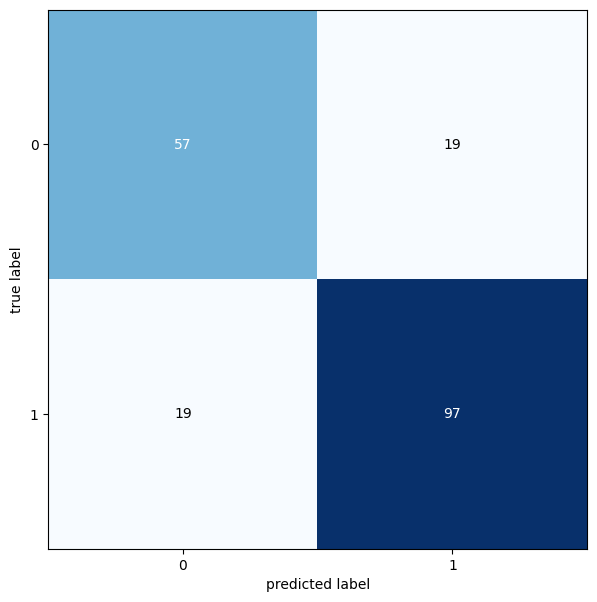

In [61]:
confusion_metric(model_2_inf,test_freq_dataloader)

# Training model_3(Model 0 namun di training menggunakan scheduler)

In [62]:
torch.manual_seed(21)
model_3 = Classification_modelv0(input_dim = 14,nodes = 128, 
                                 output_dim = 1, layer =  3)
print(model_3)

Classification_modelv0(
  (lstm): LSTM(14, 128, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


In [63]:
loss_fn3 = nn.BCEWithLogitsLoss()
optimizer3 = torch.optim.Adam(params = model_3.parameters(),lr = 0.0001)#,weight_decay = 0.0001)
scheduler3 = torch.optim.lr_scheduler.LinearLR(optimizer3, 
                                               start_factor=0.3333333333333333, 
                                               end_factor=1.0, total_iters=10, 
                                               last_epoch=- 1, verbose=False)

print(type(loss_fn3))
print(type(optimizer3))
print(type(scheduler3))

<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [65]:
epochs = 30
dict_info = {'loss_train':[],
             'acc_train':[],
             'loss_test':[],
             'acc_test':[]}

for epoch in range(epochs):
  print(f"epoch--{epoch}\n________")
  log_train,l,a = train_loop(model_3,
                         train_dataloader,
                         loss_fn3,
                         optimizer3,
                         device,
                         scheduler3)
  
  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  
  if epoch%(epochs//10) == 0:
    log_test,lt,at = model_metrics(model_3,test_dataloader,loss_fn)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
  

epoch--0
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 24

  loss_train     = 0.2937
  train_accuracy = 0.8925
  

  loss_test     = 0.3107
  test_accuracy = 0.8696
  
epoch--1
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 24

  loss_train     = 0.2975
  train_accuracy = 0.8944
  
epoch--2
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 24

  loss_train     = 0.3009
  train_accuracy = 0.8875
  
epoch--3
________
batch ke - 0
batch ke - 2
batch ke - 4
batch ke - 6
batch ke - 8
batch ke - 10
batch ke - 12
batch ke - 14
batch ke - 16
batch ke - 18
batch ke - 20
batch ke - 22
batch ke - 2

In [67]:
log_train

{'model': 'Classification_modelv0',
 'loss': 0.2544536292552948,
 'akurasi': 0.9075}

In [68]:
log_test

{'model': 'Classification_modelv0',
 'loss': 0.2751368284225464,
 'akurasi': 0.8807397995676313}

In [72]:
"""
torch.save(model_3.state_dict(),path + "3.pth")
"""

print('run this only when you get good result')

run this only when you get good result


In [75]:
model_3_inf = Classification_modelv0(input_dim = 14,nodes = 128, 
                                 output_dim = 1, layer =  3)

state3 = torch.load(path + ".pth")
model_3_inf.load_state_dict(state3)


<All keys matched successfully>

True

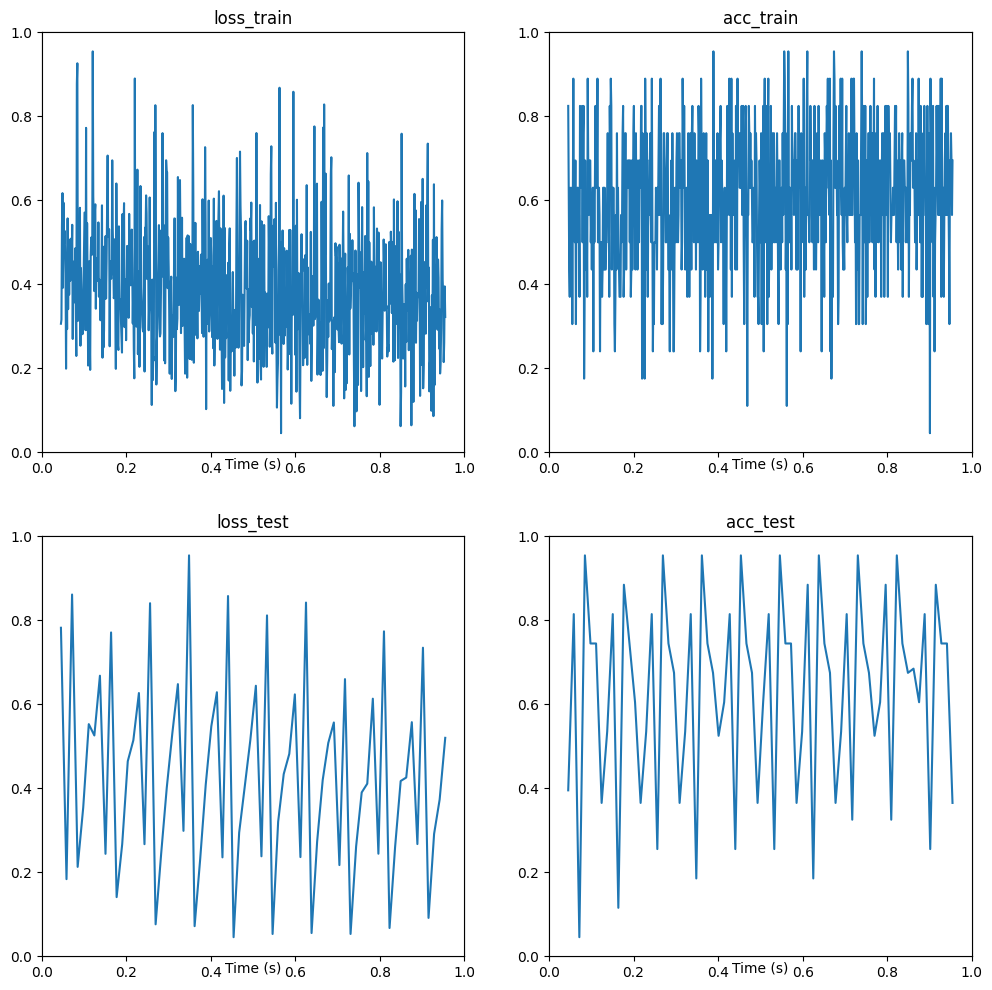

In [69]:
manual_tensorboard(dict_info)

Making predictions:   0%|          | 0/25 [00:00<?, ?it/s]

True

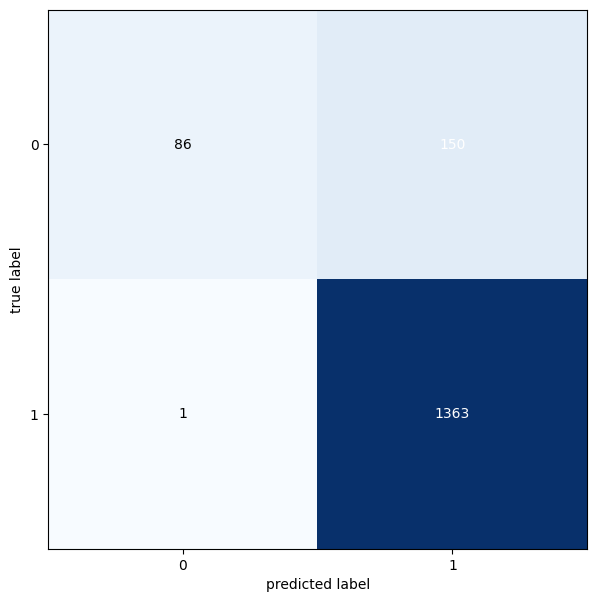

In [70]:
confusion_metric(model_3,train_dataloader)

Making predictions:   0%|          | 0/7 [00:00<?, ?it/s]

True

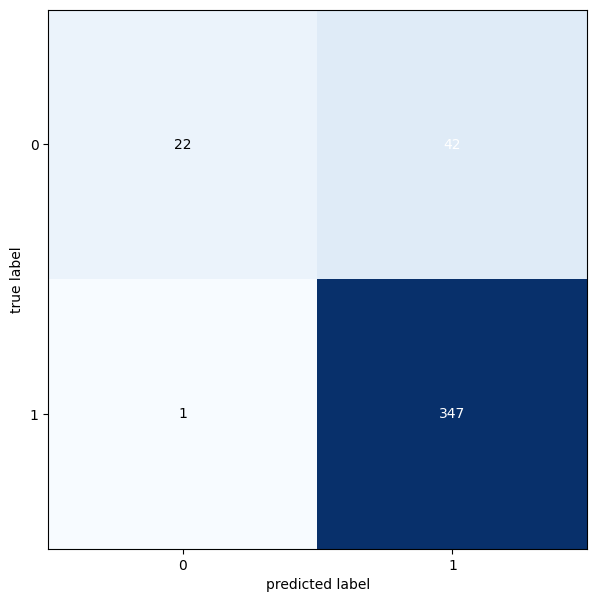

In [71]:
confusion_metric(model_3,test_dataloader)